# Extracting coherent part of internal tide 

This notebook aims at extracting the coherent part of the signal in the internal tide. The variable used is **ssh_it1** from *MITgcm_it* repertory.  

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from pyinterp import fill, Axis, TemporalAxis, Grid3D, Grid2D
import scipy.fftpack as fp
from scipy.interpolate import RegularGridInterpolator, griddata, LinearNDInterpolator
from scipy.spatial import Delaunay
from math import *
from dask import delayed,compute
from joblib import Parallel
from joblib import delayed as jb_delayed
from datetime import datetime
import glob

## 1. - Data import 

In [ ]:
list_files = glob.glob("/bettik/bellemva/MITgcm/MITgcm_it/hawaii/MITgcm_it_201205*.nc")+\
             glob.glob("/bettik/bellemva/MITgcm/MITgcm_it/hawaii/MITgcm_it_201206*.nc")+\
             glob.glob("/bettik/bellemva/MITgcm/MITgcm_it/hawaii/MITgcm_it_201207*.nc")
list_files.sort()         
ds = xr.open_mfdataset(list_files,combine='nested',concat_dim='time',parallel=True)

In [4]:
## FOR THE DATE 2012-07-06 ONLY ##
ds = xr.open_mfdataset("/bettik/bellemva/MITgcm/MITgcm_it/hawaii/MITgcm_it_201207*.nc",drop_variables=["ssh_it1_coherent"])
ds = ds.sel(time=slice(np.datetime64("2012-07-02"),np.datetime64("2012-07-11")))

In [6]:
ds_it = ds.ssh_it1.load()

## 2. - Coherent part extraction 

In [7]:
array_time = ds_it.time.values
nt = array_time.size

In [10]:
# PARAMETERS # 
wint = np.ones(3*nt)
gaspari = gaspari_cohn(np.arange(0,2*nt,1),nt,nt)
wint[:nt]=gaspari[:nt]
wint[2*nt:]=gaspari[nt:]

dt = 3600 # seconds

w = fp.fftfreq(3*nt,dt)# seconds^-1
nw = w.size

w1 = 1/((12*60+26)*60)
w2 = 1/((12*60+23)*60)

H = (np.abs(w)>w1) & (np.abs(w)<w2)
w_filtered = H*w

In [11]:
idx_ocean = np.where(np.invert(np.isnan(ds_it[0,:,:].values))) # indexes of ocean pixels

In [12]:
# PROCESSING # 
ssh_it_flat = np.array(Parallel(n_jobs=24,backend='multiprocessing')(jb_delayed(extract_it)(ds_it[:,i,j],wint,H) for i,j in zip(idx_ocean[0],idx_ocean[1])))

In [13]:
# ARRAY TO STORE THE RESULTS # 
array_ssh_it = np.nan*np.ones_like(ds_it.values,dtype="float64")
array_ssh_it[:,idx_ocean[0],idx_ocean[1]]=ssh_it_flat.T

# np.save(file="/bettik/bellemva/MITgcm/ssh_it.npy",arr=array_ssh_it)

In [11]:
del ssh_it_flat

In [ ]:
array_ssh_it=np.load("/bettik/bellemva/MITgcm/ssh_it.npy")

In [14]:
date_array = np.arange(np.datetime64("2012-05-01"),np.datetime64("2012-08-01"))

for i in range (len(date_array)) : 
    ds_it_coherent = ds_it.sel(time=slice(date_array[i],date_array[i+1]-np.timedelta64(1,'h'))).copy(deep=True,data=array_ssh_it[i*24:(i+1)*24,:,:])
    ds_it_coherent = ds_it_coherent.rename("ssh_it1_coherent")
    ds_it_coherent.to_netcdf("/bettik/bellemva/MITgcm/MITgcm_it/hawaii/coherent_part/MITgcm_it_"+date_array[i].astype('str').replace('-','')+".nc")

    print(date_array[i])

2012-07-06


IndexError: index 2 is out of bounds for axis 0 with size 2

In [ ]:
i=91
ds_it_coherent = ds_it.sel(time=slice(date_array[i],np.datetime64("2012-08-01")-np.timedelta64(1,'h'))).copy(deep=True,data=array_ssh_it[i*24:(i+1)*24,:,:])
ds_it_coherent = ds_it_coherent.rename("ssh_it1_coherent")
ds_it_coherent.to_netcdf("/bettik/bellemva/MITgcm/MITgcm_it/hawaii/coherent_part/MITgcm_it_"+date_array[i].astype('str').replace('-','')+".nc")


In [15]:
#dates = np.arange(np.datetime64("2012-05-01"),np.datetime64("2012-08-01"))
dates = np.arange(np.datetime64("2012-07-06"),np.datetime64("2012-07-07"))

# deleting the content of file.sh 
file = open("./nco_bash.sh","w")
file.close()

for d in dates:

    command = "ncks -h -A "

    command += "/bettik/bellemva/MITgcm/MITgcm_it/hawaii/coherent_part/MITgcm_it_"+d.astype('str').replace("-","")+".nc "

    command += "/bettik/bellemva/MITgcm/MITgcm_it/hawaii/MITgcm_it_"+d.astype('str').replace("-","")+".nc \n"
    
    file = open("./nco_bash.sh","a")
    
    file.write(command)

    file.close()

## 3. - Coherent part analysis 

In [3]:
ds = xr.open_dataset("/bettik/bellemva/MITgcm/MITgcm_it/hawaii/MITgcm_it_20120601.nc")
ds

<xarray.Dataset>
Dimensions:           (time: 24, latitude: 961, longitude: 961)
Coordinates:
  * latitude          (latitude) float32 15.0 15.02 15.04 ... 34.96 34.98 35.0
  * longitude         (longitude) float32 185.0 185.0 185.0 ... 205.0 205.0
  * time              (time) datetime64[ns] 2012-06-01 ... 2012-06-01T23:00:00
Data variables:
    ssh_it_tot        (time, latitude, longitude) float64 ...
    ssh_it1           (time, latitude, longitude) float64 ...
    ssh_it2           (time, latitude, longitude) float64 ...
    ssh_it3           (time, latitude, longitude) float64 ...
    ssh_it1_coherent  (time, latitude, longitude) float64 ...

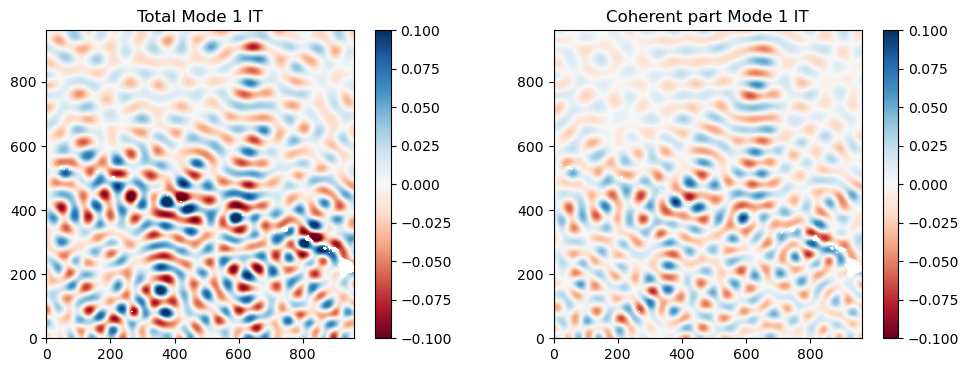

In [4]:
fig, axs = plt.subplots(1,2,figsize=(12,4))

plot0 = axs[0].pcolormesh(ds.ssh_it1[0,:,:].values,vmin=-0.1,vmax=0.1,cmap = 'RdBu')
plot1 = axs[1].pcolormesh(ds.ssh_it1_coherent[0,:,:].values,vmin=-0.1,vmax=0.1,cmap = 'RdBu')

axs[0].set_title("Total Mode 1 IT")
axs[1].set_title("Coherent part Mode 1 IT")

plt.colorbar(plot0,ax=axs[0])
plt.colorbar(plot1,ax=axs[1])

axs[0].set_aspect("equal")
axs[1].set_aspect("equal")



In [ ]:
plt.pcolormesh(ds.ssh_it1[0,:,:].values)
plt.colorbar()

In [ ]:
plt.pcolormesh(ds.ssh_it1_coherent[0,:,:].values)
plt.colorbar()

## Functions 

In [8]:
def extract_it(array_ssh,wint,H): 
    array_ssh=array_ssh.values
    ssh_extended = np.concatenate((np.flip(array_ssh),
                                   array_ssh,
                                   np.flip(array_ssh)))
    ssh_win = wint * ssh_extended 
    ssh_f_t = fp.fft(ssh_win)
    ssh_f_filtered =  H * ssh_f_t
    ssh_filtered = np.real(fp.ifft(ssh_f_filtered))[nt:2*nt]
    del array_ssh
    return ssh_filtered

In [9]:
def gaspari_cohn(array,distance,center):
    """
    NAME 
        bfn_gaspari_cohn

    DESCRIPTION 
        Gaspari-Cohn function. @vbellemin.
        
        Args: 
            array : array of value whose the Gaspari-Cohn function will be applied
            center : centered value of the function 
            distance : Distance above which the return values are zeros


        Returns:  smoothed values 
            
    """ 
    if type(array) is float or type(array) is int:
        array = np.array([array])
    else:
        array = array
    if distance<=0:
        return np.zeros_like(array)
    else:
        array = 2*np.abs(array-center*np.ones_like(array))/distance
        gp = np.zeros_like(array)
        i= np.where(array<=1.)[0]
        gp[i]=-0.25*array[i]**5+0.5*array[i]**4+0.625*array[i]**3-5./3.*array[i]**2+1.
        i =np.where((array>1.)*(array<=2.))[0]
        gp[i] = 1./12.*array[i]**5-0.5*array[i]**4+0.625*array[i]**3+5./3.*array[i]**2-5.*array[i]+4.-2./3./array[i]
        #if type(r) is float:
        #    gp = gp[0]
    return gp